In [63]:
import gym
import torch
from torch import nn #needed for building neural networks
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
from tqdm import tqdm_notebook as tqdm
import random
from copy import copy, deepcopy
from collections import deque
import numpy as np
print("Using torch version: {}".format(torch.__version__))

Using torch version: 1.0.0


In [64]:
BUFFER_SIZE=1000000
BATCH_SIZE=64
GAMMA=0.99
TAU=0.001       #Target Network HyperParameters Update rate
LRA=0.0001      #LEARNING RATE ACTOR
LRC=0.001       #LEARNING RATE CRITIC
H1=400   #neurons of 1st layers
H2=300   #neurons of 2nd layers

MAX_EPISODES=5000 #number of episodes of the training
MAX_STEPS=200    #max steps to finish an episode. An episode breaks early if some break conditions are met (like too much
                  #amplitude of the joints angles or if a failure occurs). In the case of pendulum there is no break 
                #condition, hence no environment reset,  so we just put 1 step per episode. 
buffer_start = 100 #initial warmup without training
epsilon = 1
epsilon_decay = 1./100000 #this is ok for a simple task like inverted pendulum, but maybe this would be set to zero for more
                     #complex tasks like Hopper; epsilon is a decay for the exploration and noise applied to the action is 
                     #weighted by this decay. In more complex tasks we need the exploration to not vanish so we set the decay
                     #to zero.
PRINT_EVERY = 10 #Print info about average reward every PRINT_EVERY

ENV_NAME = "Pendulum-v0" # Put here the gym env name you want to play with
#check other environments to play with at https://gym.openai.com/envs/#mujoco

### Experience Replay Buffer
It would be interesting to use prioritise experience replay. Have you ever managed to use the prioritised experience replay with DDPG? Leave a comment if you would like to share your results with prioritised experience replay. https://arxiv.org/pdf/1511.05952.pdf

In [65]:
class replayBuffer(object):
    def __init__(self, buffer_size, name_buffer=''):
        self.buffer_size=buffer_size  #choose buffer size
        self.num_exp=0
        self.buffer=deque()

    def add(self, s, a, r, t, s2):
        experience=(s, a, r, t, s2)
        if self.num_exp < self.buffer_size:
            self.buffer.append(experience)
            self.num_exp +=1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.buffer_size

    def count(self):
        return self.num_exp

    def sample(self, batch_size):
        if self.num_exp < batch_size:
            batch=random.sample(self.buffer, self.num_exp)
        else:
            batch=random.sample(self.buffer, batch_size)

        s, a, r, t, s2 = map(np.stack, zip(*batch))

        return s, a, r, t, s2

    def clear(self):
        self.buffer = deque()
        self.num_exp=0

In [66]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cuda


### Network architectures
We define here the networks. Note that better results in complex tasks (like Hopper env) have to be addressed using higher batch size (so 128 instead of 64) and with batch normalisation layers in between input and hidden layers of both actoir and critic; so uncomment the lines referring to BN to face more complex tasks.

In [67]:
def fanin_(size):
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return torch.Tensor(size).uniform_(-weight, weight)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=3e-3):
        super(Critic, self).__init__()
                
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1+action_dim, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
                
        self.linear3 = nn.Linear(h2, 1)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        
    def forward(self, state, action):
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(torch.cat([x,action],1))
        
        x = self.relu(x)
        x = self.linear3(x)
        
        return x
    

class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=0.003):
        super(Actor, self).__init__()
        
        #self.bn0 = nn.BatchNorm1d(state_dim)
        
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        
        #self.bn2 = nn.BatchNorm1d(h2)
        
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, state):
        #state = self.bn0(state)
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

### Exploration
As described in the paper, we have to add noise to the action in order to ensure exploration. An Ornstein-Uhlenbeck process is chosen because it adds noise in a smooth way, which is suitable for continuous control tasks. More details on this random process are simply described on Wikipedia: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process

In [68]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu=0, sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

Wrap state and action spaces

In [69]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

### Setup training

In [70]:
env = NormalizedEnv(gym.make(ENV_NAME))

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

critic  = Critic(state_dim, action_dim).to(device)
actor = Actor(state_dim, action_dim).to(device)

target_critic  = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)

for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
    
q_optimizer  = opt.Adam(critic.parameters(),  lr=LRC)#, weight_decay=0.01)
policy_optimizer = opt.Adam(actor.parameters(), lr=LRA)

MSE = nn.MSELoss()

memory = replayBuffer(BUFFER_SIZE)

State dim: 3, Action dim: 1


### Iterate through episodes
Let's train!

In [71]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

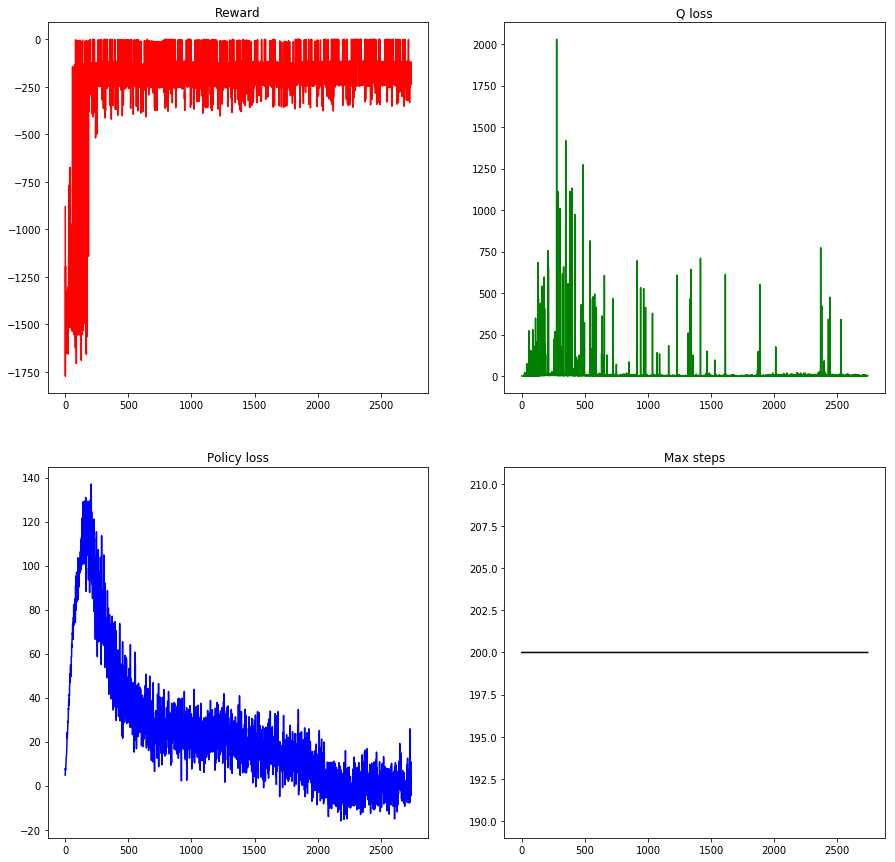

[  2740 episode,   548000 total steps] average reward for past 10 iterations: -170.636
Last model saved with reward: -0.08, at episode 2146.


KeyboardInterrupt: 

In [72]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
#s = deepcopy(env.reset())

for episode in range(MAX_EPISODES):
    #print(episode)
    s = deepcopy(env.reset())
    #noise.reset()

    ep_reward = 0.
    ep_q_value = 0.
    step=0

    for step in range(MAX_STEPS):
        #loss=0
        global_step +=1
        epsilon -= epsilon_decay
        #actor.eval()
        a = actor.get_action(s)
        #actor.train()

        a += noise()*max(0, epsilon)
        a = np.clip(a, -1., 1.)
        s2, reward, terminal, info = env.step(a)


        memory.add(s, a, reward, terminal,s2)

        #keep adding experiences to the memory until there are at least minibatch size samples
        
        if memory.count() > buffer_start:
            s_batch, a_batch, r_batch, t_batch, s2_batch = memory.sample(BATCH_SIZE)

            s_batch = torch.FloatTensor(s_batch).to(device)
            a_batch = torch.FloatTensor(a_batch).to(device)
            r_batch = torch.FloatTensor(r_batch).unsqueeze(1).to(device)
            t_batch = torch.FloatTensor(np.float32(t_batch)).unsqueeze(1).to(device)
            s2_batch = torch.FloatTensor(s2_batch).to(device)
            
            
            #compute loss for critic
            a2_batch = target_actor(s2_batch)
            target_q = target_critic(s2_batch, a2_batch) #detach to avoid updating target
            y = r_batch + (1.0 - t_batch) * GAMMA * target_q.detach()
            q = critic(s_batch, a_batch)
            
            q_optimizer.zero_grad()
            q_loss = MSE(q, y) #detach to avoid updating target
            q_loss.backward()
            q_optimizer.step()
            
            #compute loss for actor
            policy_optimizer.zero_grad()
            policy_loss = -critic(s_batch, actor(s_batch))
            policy_loss = policy_loss.mean()
            policy_loss.backward()
            policy_optimizer.step()
            
            #soft update of the frozen target networks
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

        s = deepcopy(s2)
        ep_reward += reward


        #if terminal:
        #    noise.reset()
        #    break

    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])
    except:
        continue
    average_reward += ep_reward
    
    if ep_reward > best_reward:
        torch.save(actor.state_dict(), 'best_model_pendulum.pkl') #Save the actor model for future testing
        best_reward = ep_reward
        saved_reward = ep_reward
        saved_ep = episode+1

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
              (episode + 1, global_step, average_reward / PRINT_EVERY))
        print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        average_reward = 0 #reset average reward